In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pymongo
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib.ticker import FuncFormatter as ff
plt.style.use('fivethirtyeight')

import re
import nltk
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob

from datetime import datetime, timedelta

In [2]:
#creates connection to mongodb
client = pymongo.MongoClient()
db = client.tweeter

In [3]:
bernie_coll = db.bernie_tweets
joe_coll = db.joe_tweets
pete_coll = db.pete_tweets
warren_coll = db.warren_tweets
amy_coll = db.amy_tweets

In [4]:
#retrieved data from mongo into a dataframe
bernie_df = pd.DataFrame(list(bernie_coll.find()))
joe_df = pd.DataFrame(list(joe_coll.find()))
pete_df = pd.DataFrame(list(pete_coll.find()))
warren_df = pd.DataFrame(list(warren_coll.find()))
amy_df = pd.DataFrame(list(amy_coll.find()))

In [ ]:
# b_df = bernie_df[~bernie_df['text'].isnull()]

In [ ]:
# df = b_df.set_index('date')
# df.index = pd.to_datetime(df.index)
# df['year'] = df.index.year
# df['month'] = df.index.month
# df['wk_name'] = df.index.weekday_name

In [56]:
def sentiment_analyser(df):
    df = df[~df['text'].isnull()]
    df.loc[:,'text'] = df.loc[:,'text'].apply(lambda x: remove_url(x))
    n_df = df[~df['text'].isnull()]
    
    sentiment_objects = [TextBlob(tweet) for tweet in n_df['text']]
    # Create list of polarity valuesx and tweet text
    sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]
    # Create dataframe containing the polarity value and tweet text
    sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"])

    sent_df = n_df.merge(sentiment_df, left_on='text', right_on='tweet')
    
    sent_pol = []
    for x in sent_df['polarity']:
        if x == 0.000000:
            sent_pol.append('neutral')
        elif x > 0.000000:
            sent_pol.append('positive')
        elif x < 0.000000:
            sent_pol.append('negative')
    
    sent_df['sent_pol'] = sent_pol
    
    output_df = sent_df.set_index('date')
    output_df.index = pd.to_datetime(output_df.index)
    output_df['year'] = output_df.index.year
    output_df['month'] = output_df.index.month
    output_df['day'] = output_df.index.day
    output_df['wk_name'] = output_df.index.weekday_name
    
    return output_df

In [37]:
def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

In [7]:
def plot_sentiment(df):
    #plot data
    fig, ax = plt.subplots(figsize=(8, 6))
    # Plot histogram of the polarity values
    sentiment_df.hist(bins=[-1, -0.90, -.80, -.70, -.60, -0.50, -.40 ,-.30, -0.20,-.10, 
                            0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1],
                 ax=ax,
                 color="purple")

    plt.title(title)
    return plt.show()

In [8]:
def tweets_per_day(df):
    cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    result = df['wk_name'].value_counts().reindex(cats).reset_index().rename(columns={'index':'weekday', 'wk_name':'num_tweets'})
    return result

In [154]:
bernie_sentiment = sentiment_analyser(bernie_df)
joe_sentiment = sentiment_analyser(joe_df)
pete_sentiment = sentiment_analyser(pete_df)
warren_sentiment = sentiment_analyser(warren_df)
amy_sentiment = sentiment_analyser(amy_df)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



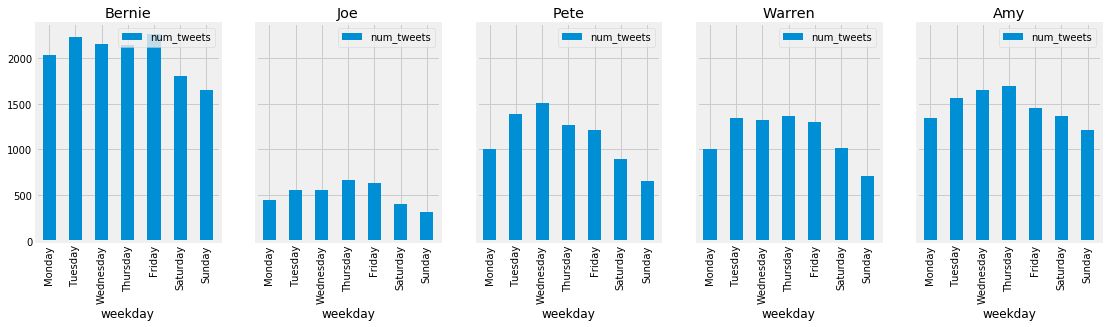

In [58]:
fig, ax = plt.subplots(1,5, figsize=(17,4), sharey=True, sharex=True)
tweets_per_day(bernie_sentiment).plot(kind='bar',x='weekday', y='num_tweets', ax=ax[0], title='Bernie')
tweets_per_day(joe_sentiment).plot(kind='bar',x='weekday', y='num_tweets', ax=ax[1], title='Joe')
tweets_per_day(pete_sentiment).plot(kind='bar',x='weekday', y='num_tweets', ax=ax[2], title='Pete')
tweets_per_day(warren_sentiment).plot(kind='bar',x='weekday', y='num_tweets', ax=ax[3], title='Warren')
tweets_per_day(amy_sentiment).plot(kind='bar',x='weekday', y='num_tweets', ax=ax[4], title='Amy')
plt.legend()
plt.show()

In [59]:
def polarity_bydate(df, yr=None, mm=None, dd=None):
    '''
    creates a polarity graph based on dates selected. 
    '''
    try:
        if yr!=None and mm!=None and dd!=None:
            query = df[(df['year']==yr)&(df['month']==mm)&(df['day']==dd)]['polarity']
        elif yr!=None and mm!=None:
            query = df[(df['year']==yr)&(df['month']==mm)]['polarity']
        elif mm!=None and dd!=None:
            query = df[(df['month']==mm)&(df['day']==mm)]['polarity']
        elif yr!=None and dd!=None:
            query = df[(df['year']==yr)&(df['day']==mm)]['polarity']
        elif yr!=None:
            query = df[df['year']==yr]['polarity']
        elif mm!=None:
            query = df[df['month']==mm]['polarity']    
        elif dd!=None:
            query = df[df['day']==mm]['polarity']   

        #plot data
        fig, ax = plt.subplots(figsize=(8, 6))

        # Plot histogram of the polarity values
        query.hist(bins=[-1, -0.90, -.80, -.70, -.60, -0.50, -.40 ,-.30, -0.20,-.10, 
                                0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1],
                     ax=ax,
                     color="purple")

        plt.title("Sentiments from Tweets from Bernie")
        return plt.show()
    
    except:
        return print('please provide a year, month, or day to filter by')

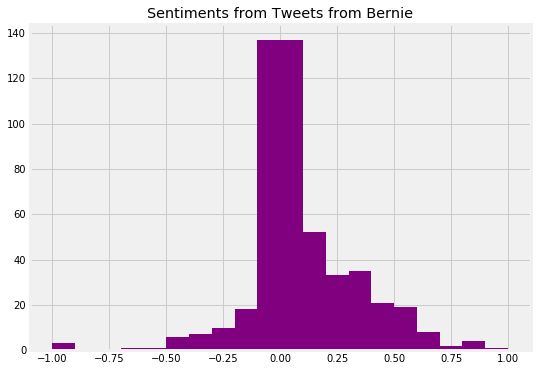

In [23]:
polarity_bydate(df=bernie_sentiment, yr=2020, mm=1)

In [ ]:
sentiment_objects = [TextBlob(tweet) for tweet in b_df['text']]

In [ ]:
# Create list of polarity valuesx and tweet text
sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]

In [ ]:
# Create dataframe containing the polarity value and tweet text
sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"])

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the polarity values
sentiment_df.hist(bins=[-1, -0.90, -.80, -.70, -.60, -0.50, -.40 ,-.30, -0.20,-.10, 
                        0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets from Bernie")
plt.show()

In [ ]:
# Remove polarity values equal to zero
sentiment_df = sentiment_df[sentiment_df.polarity != 0]
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram with break at zero
sentiment_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets from Bernie")
plt.show()

In [12]:
def tweet_mention_hash_plot(df, rate='M'):
    df.resample(rate)[['text', 'mentions', 'hashtags']].count().plot()
    return plt.show()

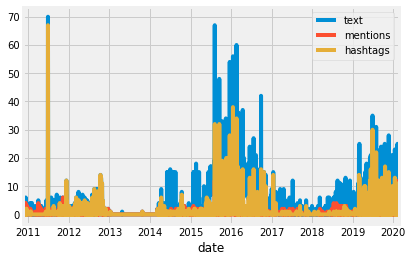

In [13]:
tweet_mention_hash_plot(bernie_sentiment, 'D')

In [ ]:
# def polyplot(df):
#     n_df = df[~df['text'].isnull()]
#     show_df = n_df.set_index('date')
#     show_df.index = pd.to_datetime(show_df.index)

#     show_df.resample('M')['text'].count().plot()
#     show_df.resample('M')['mentions'].count().plot()
#     return plt.show()

In [ ]:
# polyplot(joe_df)

In [151]:
def retweet_fav_reply_plot(df, title, rate='M', asof=None, figsize=(12,8)):
    if asof is not None:
        df = df[df.index > (asof - timedelta(days=30))]
    
    fig, ax = plt.subplots(figsize=figsize)
    df.resample(rate)[['retweets', 'favorites', 'replies']].mean().plot(ax=ax)
    ax.get_yaxis().set_major_formatter(ff(lambda x, p: format(int(x), ',')))
    ax.legend(fancybox=True, frameon=True, framealpha=1, shadow=True, borderpad=1, title='Twitter Interaction')
    plt.title(title)
    return plt.show()

In [157]:
def data_filter(df, asof=None, dateadj=None):
    if asof is not None:
        df = df[df.index > (asof - timedelta(days=dateadj))]
    
    result = df[['text', 'polarity', 'wk_name','favorites']]
    return result

In [26]:
bern_ann= pd.to_datetime('2/19/2019')
joe_ann= pd.to_datetime('4/25/2019')
pete_ann= pd.to_datetime('1/23/2019')
warren_ann= pd.to_datetime('12/31/2018')
amy_ann= pd.to_datetime('2/10/2019')

In [16]:
def polyplot(df, rate='M'):
    n_df = df[~df['text'].isnull()]
    show_df = n_df.set_index('date')
    show_df.index = pd.to_datetime(show_df.index)
    return show_df.resample(rate)['text'].count()

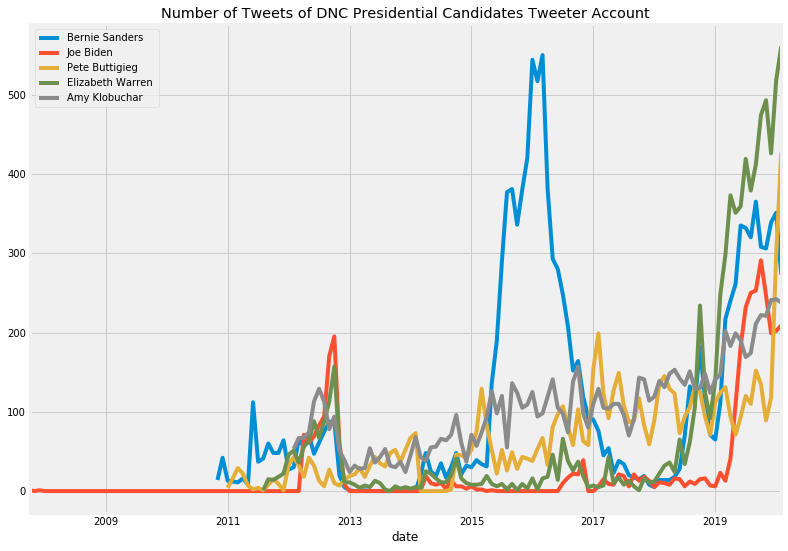

In [17]:
fig, ax = plt.subplots(figsize=(12,9))
polyplot(bernie_df).plot()
polyplot(joe_df).plot()
polyplot(pete_df).plot()
polyplot(warren_df).plot()
polyplot(amy_df).plot()
labels = ['Bernie Sanders', 'Joe Biden', 'Pete Buttigieg', 'Elizabeth Warren ', 'Amy Klobuchar']
plt.legend(labels)
plt.title('Number of Tweets of DNC Presidential Candidates Tweeter Account')
plt.show()

In [18]:
data = pd.concat([polyplot(bernie_df, rate='D'),polyplot(joe_df, rate='D'), 
                  polyplot(pete_df, rate='D'), polyplot(warren_df, rate='D'),
                  polyplot(amy_df, rate='D')], axis=1)

cols = ['bernie', 'joe', 'pete', 'warren', 'amy']
data.columns = cols

In [19]:
data.head()

bernie  joe  pete  warren  amy
date                                      
2007-10-24     NaN    1   NaN     NaN  NaN
2007-10-25     NaN    0   NaN     NaN  NaN
2007-10-26     NaN    0   NaN     NaN  NaN
2007-10-27     NaN    0   NaN     NaN  NaN
2007-10-28     NaN    0   NaN     NaN  NaN

In [20]:
def plot_trend(x, y):
    title = "{} Tweets Trends".format(y.capitalize())
    fig=px.line(data, x=x, y=y, title=title)
    return fig.show()

In [21]:
plot_trend(data.index, 'warren')
plot_trend(data.index, 'joe')

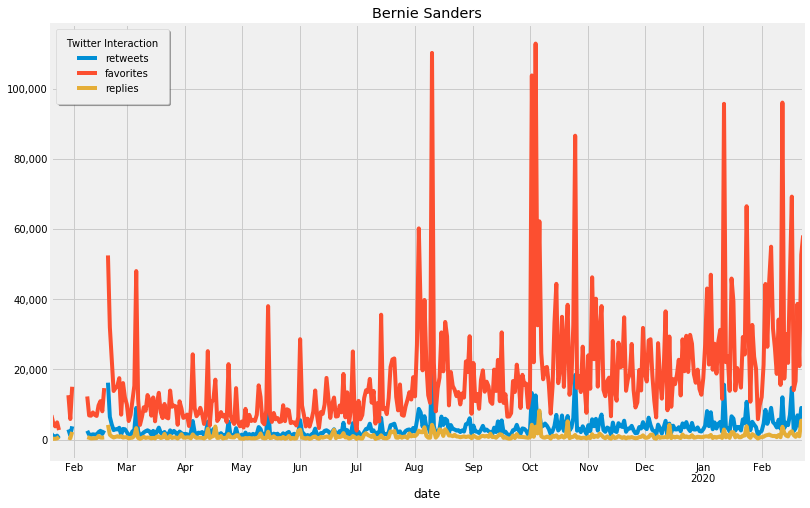

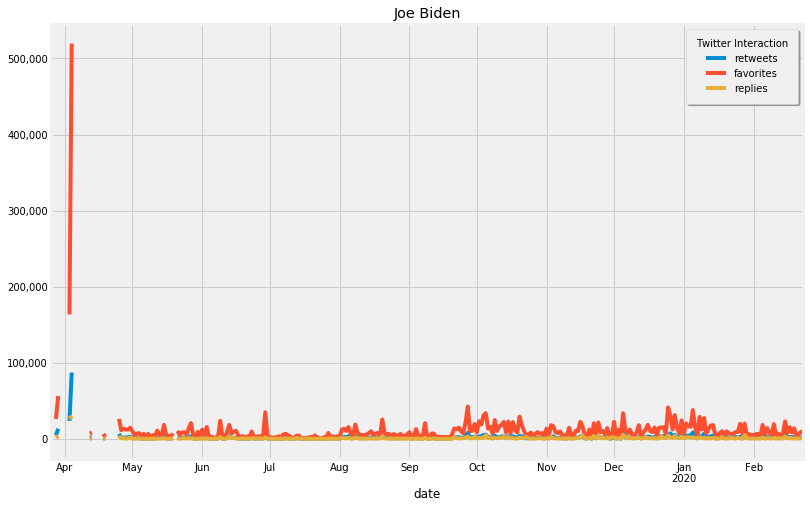

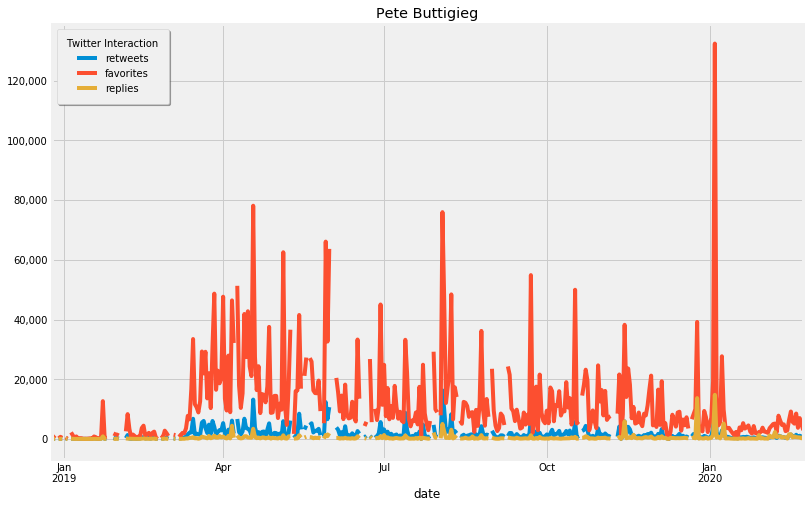

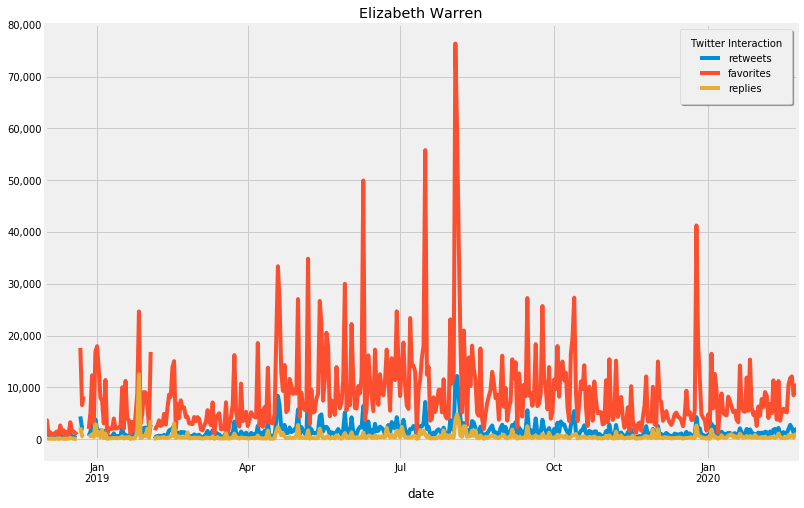

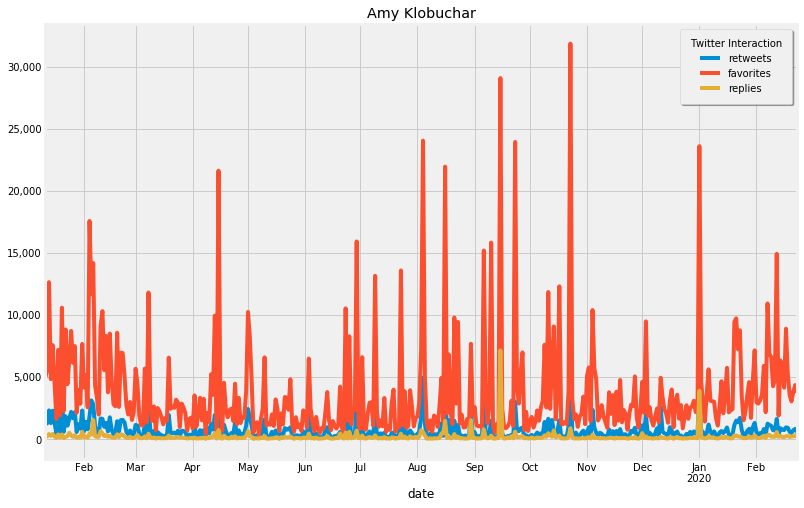

In [192]:
retweet_fav_reply_plot(bernie_sentiment, 'Bernie Sanders', rate='D', asof=bern_ann)
retweet_fav_reply_plot(joe_sentiment, 'Joe Biden', rate='D', asof=joe_ann)
retweet_fav_reply_plot(pete_sentiment, 'Pete Buttigieg', rate='D', asof=pete_ann)
retweet_fav_reply_plot(warren_sentiment, 'Elizabeth Warren', rate='D', asof=warren_ann)
retweet_fav_reply_plot(amy_sentiment, 'Amy Klobuchar', rate='D', asof=amy_ann)

In [28]:
def election_timeperiod(df, asof=None, days_adj=7):
    cols = ['polarity','retweets', 'favorites', 'replies']
    df = df[cols]
    return df[df.index > (asof - timedelta(days=days_adj))]

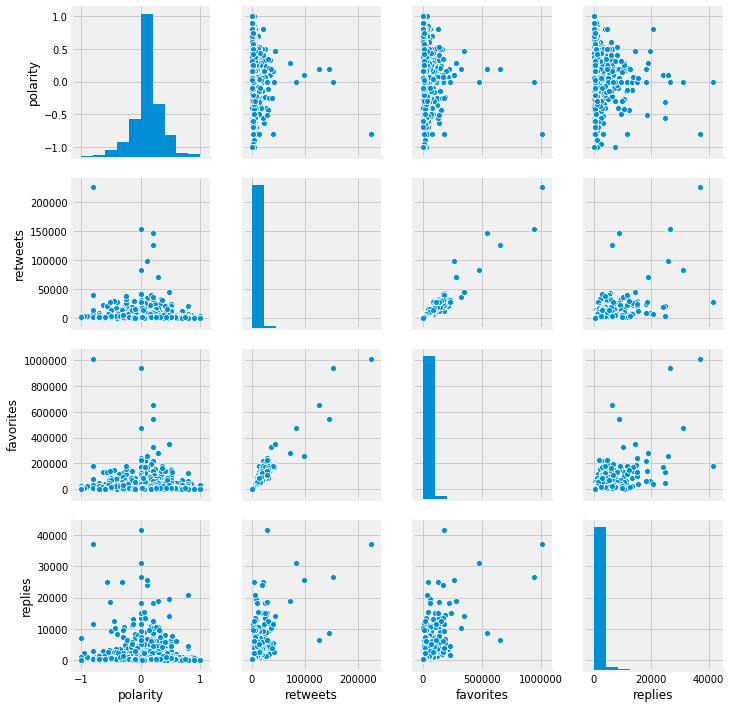

In [153]:
sns.pairplot(election_timeperiod(bernie_sentiment, bern_ann))
plt.show()

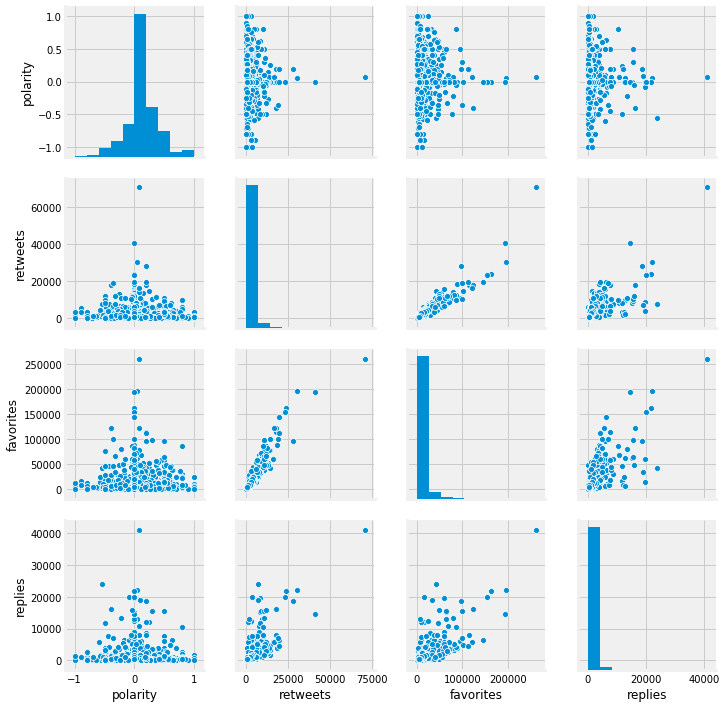

In [36]:
sns.pairplot(election_timeperiod(joe_sentiment, joe_ann))
plt.show()

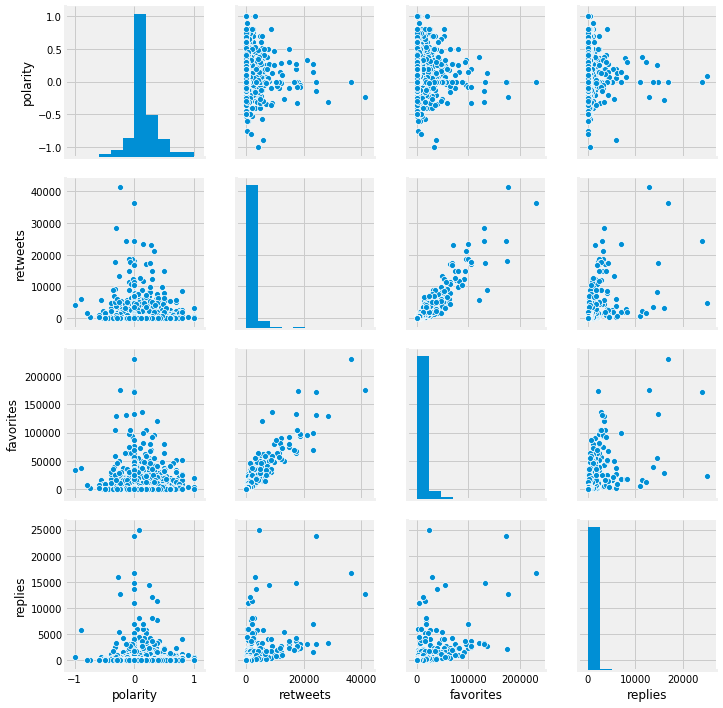

In [37]:
sns.pairplot(election_timeperiod(pete_sentiment, pete_ann))
plt.show()

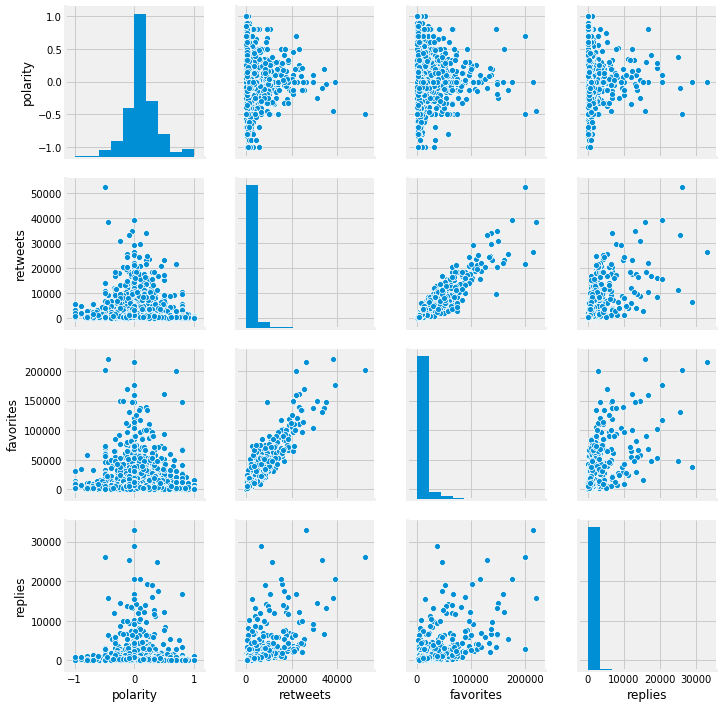

In [38]:
sns.pairplot(election_timeperiod(warren_sentiment, warren_ann))
plt.show()

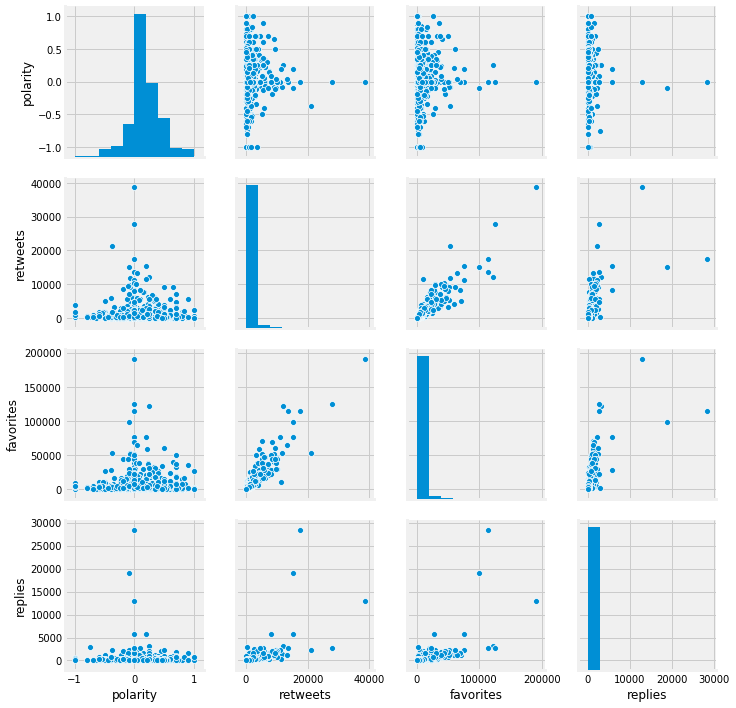

In [39]:
sns.pairplot(election_timeperiod(amy_sentiment, amy_ann))
plt.show()

In [40]:
def noun_phrase_wordlist(df):
    wordlist = pd.DataFrame()
    for t in df['text']:
        tx = TextBlob(t)
        l = list(tx.noun_phrases)
        if len(l)!=0:
            wordlist = wordlist.append(l)
    return wordlist

In [43]:
bern_wordlist = noun_phrase_wordlist(bernie_sentiment)
bern_allwords = bern_wordlist.groupby(0).size()

In [44]:
joe_wordlist = noun_phrase_wordlist(joe_sentiment)
joe_allwords = joe_wordlist.groupby(0).size()

In [45]:
pete_wordlist = noun_phrase_wordlist(pete_sentiment)
pete_allwords = pete_wordlist.groupby(0).size()

In [46]:
warren_wordlist = noun_phrase_wordlist(warren_sentiment)
warren_allwords = warren_wordlist.groupby(0).size()

In [47]:
amy_wordlist = noun_phrase_wordlist(amy_sentiment)
amy_allwords = amy_wordlist.groupby(0).size()

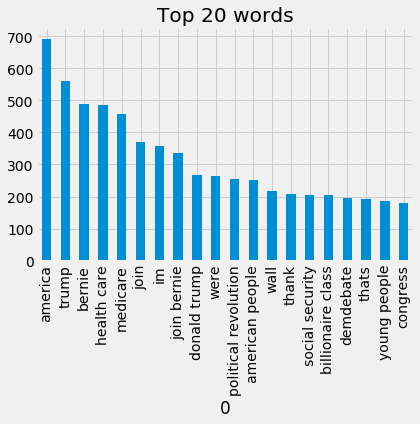

In [54]:
top20allword = bern_allwords.sort_values(0,ascending=False).head(20)
top20allword.plot(kind='bar',title='Top 20 words')
plt.show()

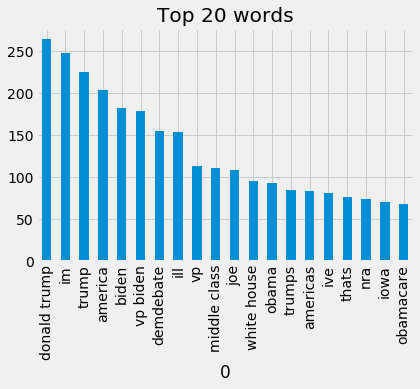

In [55]:
top20allword = joe_allwords.sort_values(0,ascending=False).head(20)
top20allword.plot(kind='bar',title='Top 20 words')
plt.show()

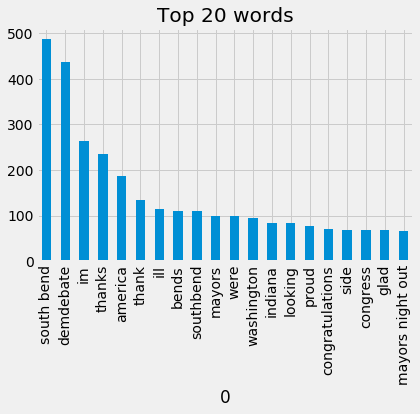

In [56]:
top20allword = pete_allwords.sort_values(0,ascending=False).head(20)
top20allword.plot(kind='bar',title='Top 20 words')
plt.show()

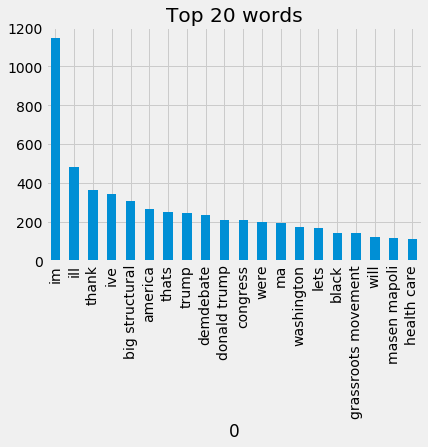

In [52]:
top20allword = warren_allwords.sort_values(0,ascending=False).head(20)
top20allword.plot(kind='bar',title='Top 20 words')
plt.show()

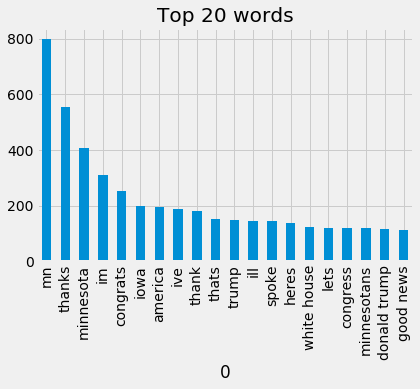

In [53]:
top20allword = amy_allwords.sort_values(0,ascending=False).head(20)
top20allword.plot(kind='bar',title='Top 20 words')
plt.show()

In [176]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

#########RandomForestClassifier
# Fitting classifier to the Training set
from sklearn.ensemble import RandomForestRegressor
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix

In [177]:
bern_features = data_filter(bernie_sentiment, asof=bern_ann, dateadj=7)

In [178]:
bern_features.head()

text  \
date                                                                     
2020-02-23 23:08:28  We won the popular vote in Iowa we won the New...   
2020-02-23 23:04:57  This campaign has the momentum to win but we c...   
2020-02-23 22:34:47  As president I will support the rights of both...   
2020-02-23 22:34:46  The Israeli people have the right to live in p...   
2020-02-23 20:20:37  Trump and his friends think theyre going to wi...   

                     polarity wk_name  favorites  
date                                              
2020-02-23 23:08:28  0.318182  Sunday      23609  
2020-02-23 23:04:57  0.408333  Sunday       4533  
2020-02-23 22:34:47  0.000000  Sunday      44742  
2020-02-23 22:34:46  0.140693  Sunday      97230  
2020-02-23 20:20:37  0.470000  Sunday      63002

In [182]:
corpus = []
for i in range(len(bern_features['text'])):
    review = re.sub('[^a-zA-Z]',' ',bern_features['text'][i])
    review = review.lower()
    review = review.split() #convert into list
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

In [183]:
y= bern_features['favorites'].values

In [184]:
#bag of words model
tfidf = TfidfVectorizer(stop_words='english')
X = tfidf.fit_transform(corpus).toarray()

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [88]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [186]:
regressor = RandomForestRegressor(n_estimators=300, max_features=2000)

In [187]:
regressor.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=2000, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [188]:
y_pred = regressor.predict(X_test)

In [144]:
from sklearn import metrics

print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred),2))

Mean Absolute Error: 33151.21


In [94]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [145]:
errors = metrics.mean_absolute_error(y_test, y_pred)
# print(classification_report(y_test,y_pred))
# print(accuracy_score(y_test, y_pred))

In [189]:
importance = regressor.feature_importances_

In [204]:
np.sum(y<1000)

66

In [190]:
regressor.score(X_train, y_train)

0.8257480786512005

In [191]:
regressor.score(X_test, y_test)

0.12953373349448272

In [123]:
std = np.std([regressor.feature_importances_ for tree in regressor.estimators_],
             axis=0)
indices = np.argsort(importance)[::-1]

1. feature 3602 (0.130664)
2. feature 14 (0.085088)
3. feature 2673 (0.050964)
4. feature 2512 (0.033001)
5. feature 1741 (0.019658)
6. feature 1314 (0.017668)
7. feature 408 (0.015578)
8. feature 4294 (0.015337)
9. feature 462 (0.015295)
10. feature 3636 (0.014960)
11. feature 3444 (0.010338)
12. feature 3257 (0.010161)
13. feature 1966 (0.009643)
14. feature 1320 (0.008669)
15. feature 2364 (0.008321)
16. feature 2152 (0.008055)
17. feature 4736 (0.007815)
18. feature 4344 (0.007431)
19. feature 4537 (0.007410)
20. feature 909 (0.006539)
21. feature 184 (0.006458)
22. feature 2302 (0.006457)
23. feature 283 (0.006056)
24. feature 4416 (0.005819)
25. feature 279 (0.005236)
26. feature 1063 (0.005204)
27. feature 623 (0.004975)
28. feature 3573 (0.004836)
29. feature 154 (0.004420)
30. feature 4346 (0.004326)
31. feature 3912 (0.004207)
32. feature 83 (0.004063)
33. feature 4094 (0.004042)
34. feature 2035 (0.003857)
35. feature 3297 (0.003809)
36. feature 1274 (0.003796)
37. feature 4

1518. feature 920 (0.000008)
1519. feature 3828 (0.000008)
1520. feature 1826 (0.000008)
1521. feature 631 (0.000008)
1522. feature 4207 (0.000008)
1523. feature 4587 (0.000008)
1524. feature 1003 (0.000008)
1525. feature 1572 (0.000008)
1526. feature 525 (0.000008)
1527. feature 3857 (0.000007)
1528. feature 72 (0.000007)
1529. feature 4468 (0.000007)
1530. feature 2929 (0.000007)
1531. feature 4167 (0.000007)
1532. feature 545 (0.000007)
1533. feature 2702 (0.000007)
1534. feature 4784 (0.000007)
1535. feature 407 (0.000007)
1536. feature 1399 (0.000007)
1537. feature 530 (0.000007)
1538. feature 2145 (0.000007)
1539. feature 3796 (0.000007)
1540. feature 2022 (0.000007)
1541. feature 3877 (0.000007)
1542. feature 453 (0.000007)
1543. feature 438 (0.000007)
1544. feature 1125 (0.000007)
1545. feature 4875 (0.000007)
1546. feature 2333 (0.000007)
1547. feature 2688 (0.000007)
1548. feature 2990 (0.000007)
1549. feature 3188 (0.000007)
1550. feature 562 (0.000007)
1551. feature 323 (0.

3017. feature 411 (0.000000)
3018. feature 3487 (0.000000)
3019. feature 3586 (0.000000)
3020. feature 662 (0.000000)
3021. feature 1124 (0.000000)
3022. feature 804 (0.000000)
3023. feature 4589 (0.000000)
3024. feature 915 (0.000000)
3025. feature 4500 (0.000000)
3026. feature 3536 (0.000000)
3027. feature 2183 (0.000000)
3028. feature 2714 (0.000000)
3029. feature 1907 (0.000000)
3030. feature 833 (0.000000)
3031. feature 1800 (0.000000)
3032. feature 2215 (0.000000)
3033. feature 511 (0.000000)
3034. feature 2889 (0.000000)
3035. feature 864 (0.000000)
3036. feature 4836 (0.000000)
3037. feature 4159 (0.000000)
3038. feature 4907 (0.000000)
3039. feature 4454 (0.000000)
3040. feature 4624 (0.000000)
3041. feature 1073 (0.000000)
3042. feature 4270 (0.000000)
3043. feature 2029 (0.000000)
3044. feature 2707 (0.000000)
3045. feature 148 (0.000000)
3046. feature 751 (0.000000)
3047. feature 2529 (0.000000)
3048. feature 1813 (0.000000)
3049. feature 4157 (0.000000)
3050. feature 4069 

4719. feature 887 (0.000000)
4720. feature 892 (0.000000)
4721. feature 974 (0.000000)
4722. feature 975 (0.000000)
4723. feature 3104 (0.000000)
4724. feature 3053 (0.000000)
4725. feature 1070 (0.000000)
4726. feature 3056 (0.000000)
4727. feature 1080 (0.000000)
4728. feature 4570 (0.000000)
4729. feature 1086 (0.000000)
4730. feature 1090 (0.000000)
4731. feature 4792 (0.000000)
4732. feature 3058 (0.000000)
4733. feature 1096 (0.000000)
4734. feature 3343 (0.000000)
4735. feature 3048 (0.000000)
4736. feature 4562 (0.000000)
4737. feature 3346 (0.000000)
4738. feature 1111 (0.000000)
4739. feature 1069 (0.000000)
4740. feature 1059 (0.000000)
4741. feature 3101 (0.000000)
4742. feature 1016 (0.000000)
4743. feature 3332 (0.000000)
4744. feature 3100 (0.000000)
4745. feature 995 (0.000000)
4746. feature 3095 (0.000000)
4747. feature 1008 (0.000000)
4748. feature 4779 (0.000000)
4749. feature 4584 (0.000000)
4750. feature 1052 (0.000000)
4751. feature 3083 (0.000000)
4752. feature 1

NameError: name 'importances' is not defined

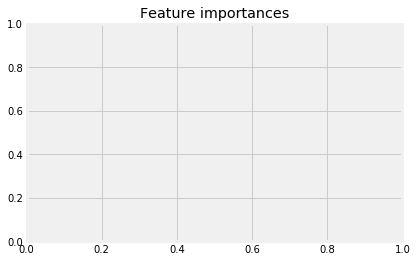

In [124]:
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importance[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [158]:
bern_f = pd.get_dummies(bern_features, columns=['wk_name'], drop_first=True)

In [162]:
df = bern_f.iloc[:,1:]

In [165]:
y = df.pop('favorites')
X = df

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [167]:
regressor = RandomForestRegressor()
regressor.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [168]:
regressor.score(X_train, y_train)

0.2632051418538277

In [169]:
regressor.score(X_test, y_test)

-0.012967437634381573